# Demand Prediction Brazilian E-Commerce

**Description**

This project aims to predict future demand using a time series model. The seller can prepare for conditions by keeping stock of their products available by predicting future demand. The data used is e-commerce transaction data from 2016 to 2018.

**Variabel**

- Timestamp: the date the order was made
- Quantity : Number of requests for product categories (in this case using the order_item_id feature which is summed because there is no product quantity feature from the existing data)
- Day: Day or date on the order data
- Month : The month of the order in which the transaction was made.
- Year : The year of the order in which the transaction was made.
- Day of week : The number of days in the week the transaction is made
- Day of year : The number of days in the year the transaction was made
- Category: Product category purchased by the customer

**Evaluation**

In this model, the Mean Absolute Error (MAE) metric will be used to evaluate the performance of the model. The MAE with the smallest value will be selected.

**Disclaimer**

In this project, we will predict the number of requests based on product categories. This is done because, based on the product ID, the number of order quantities is small. The daily demand predictions that will be made are from August 30, 2018, to September 30, 2019.

## Import Packages

To create a prediction model this time, we will use automatic machine learning, namely the Pycaret library. With this library, it will be easier to determine which model has the best performance.

In [1]:
# --- Importing Libraries ---
import datetime
import numpy as np
import pandas as pd
import warnings
import pycaret
import plotly.express as px
import os
from pycaret.regression import *

# --- Libraries Settings ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
#pd.set_option('display.float_format', lambda x: '%.0f' % x)

## Load Dataset

In [557]:
Orders = pd.read_csv('olist_orders_dataset.csv')
Products = pd.read_csv('olist_products_dataset.csv')
Order_items = pd.read_csv('olist_order_items_dataset.csv')
Product_category_name = pd.read_csv('product_category_name_translation.csv')

In [558]:
# extract the data we need
Orders = Orders[Orders['order_status'] == 'delivered']
df_orders = Orders[['order_id','order_purchase_timestamp']]
df_order_items = Order_items[['order_id', 'order_item_id','product_id','price']]
df_products = Products[['product_id','product_category_name']].merge(Product_category_name, how='left', on='product_category_name').drop(columns='product_category_name')

In [559]:
# merge datasets
Combined_2 = pd.merge(df_orders,df_order_items,left_on='order_id',right_on='order_id')
dataset = Combined_2.merge(df_products,on ='product_id')

In [560]:
dataset = dataset.rename(columns={'product_category_name_english':'category',
                  'order_purchase_timestamp':'timestamp'})

In [561]:
dataset

,order_id,timestamp,order_item_id,product_id,price,category
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,29.99,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,29.99,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,29.99,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,29.99,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery
...,...,...,...,...,...,...
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure
110193,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,2,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty


## Exploratory Data Analysis

In [562]:
dataset.shape

(110197, 6)

In [563]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 110196
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       110197 non-null  object 
 1   timestamp      110197 non-null  object 
 2   order_item_id  110197 non-null  int64  
 3   product_id     110197 non-null  object 
 4   price          110197 non-null  float64
 5   category       108638 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [564]:
dataset.isnull().sum()

order_id            0
timestamp           0
order_item_id       0
product_id          0
price               0
category         1559
dtype: int64

In [565]:
# Drop duplicates
dataset.drop_duplicates(subset=['order_id'], keep="first", inplace=True)

In [566]:
dataset

,order_id,timestamp,order_item_id,product_id,price,category
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,29.99,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,29.99,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,29.99,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,29.99,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery
...,...,...,...,...,...,...
110191,87b4c933f31145a28413b39d880ad6c3,2018-03-02 17:12:05,1,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty


In [567]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 110196
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       96478 non-null  object 
 1   timestamp      96478 non-null  object 
 2   order_item_id  96478 non-null  int64  
 3   product_id     96478 non-null  object 
 4   price          96478 non-null  float64
 5   category       95103 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


In [568]:
dataset

,order_id,timestamp,order_item_id,product_id,price,category
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,29.99,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,29.99,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,29.99,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,29.99,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery
...,...,...,...,...,...,...
110191,87b4c933f31145a28413b39d880ad6c3,2018-03-02 17:12:05,1,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty


In [569]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset

,order_id,timestamp,order_item_id,product_id,price,category
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,29.99,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,29.99,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,29.99,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,29.99,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery
...,...,...,...,...,...,...
110191,87b4c933f31145a28413b39d880ad6c3,2018-03-02 17:12:05,1,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty


In [570]:
dataset['Month'] = [i.month for i in dataset['timestamp']]

In [571]:
dataset['Year'] = [i.year for i in dataset['timestamp']]

In [572]:
dataset

,order_id,timestamp,order_item_id,product_id,price,category,Month,Year
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,29.99,housewares,10,2017
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,29.99,housewares,8,2017
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,29.99,housewares,8,2017
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,29.99,housewares,10,2017
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery,7,2018
...,...,...,...,...,...,...,...,...
110191,87b4c933f31145a28413b39d880ad6c3,2018-03-02 17:12:05,1,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty,3,2018
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10 21:21:07,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure,8,2017
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments,12,2017
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty,3,2017


In [573]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp']).dt.date
dataset

,order_id,timestamp,order_item_id,product_id,price,category,Month,Year
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,1,87285b34884572647811a353c7ac498a,29.99,housewares,10,2017
1,128e10d95713541c87cd1a2e48201934,2017-08-15,1,87285b34884572647811a353c7ac498a,29.99,housewares,8,2017
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,1,87285b34884572647811a353c7ac498a,29.99,housewares,8,2017
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,1,87285b34884572647811a353c7ac498a,29.99,housewares,10,2017
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,1,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumery,7,2018
...,...,...,...,...,...,...,...,...
110191,87b4c933f31145a28413b39d880ad6c3,2018-03-02,1,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty,3,2018
110192,e8fd20068b9f7e6ec07068bb7537f781,2017-08-10,1,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure,8,2017
110194,cfa78b997e329a5295b4ee6972c02979,2017-12-20,1,3d2c44374ee42b3003a470f3e937a2ea,55.90,musical_instruments,12,2017
110195,9c5dedf39a927c1b2549525ed64a053c,2017-03-09,1,ac35486adb7b02598c182c2ff2e05254,72.00,health_beauty,3,2017


In [574]:
dataset['order_id'].duplicated().sum()

0

### Data Agregation for Demand Prediction Model

In [575]:
# agregation
orders = dataset.groupby(['category', 'timestamp']).agg(
                                Total_Order=pd.NamedAgg(column="order_item_id", aggfunc="sum")).reset_index()

orders.head(20)

,category,timestamp,Total_Order
0,agro_industry_and_commerce,2017-01-23,1
1,agro_industry_and_commerce,2017-01-31,1
2,agro_industry_and_commerce,2017-02-05,1
3,agro_industry_and_commerce,2017-02-08,1
4,agro_industry_and_commerce,2017-02-12,1
5,agro_industry_and_commerce,2017-02-13,1
6,agro_industry_and_commerce,2017-02-16,1
7,agro_industry_and_commerce,2017-02-18,1
8,agro_industry_and_commerce,2017-02-21,1
9,agro_industry_and_commerce,2017-03-17,1


### Calculate Matrix Covariance from Total Order

In [576]:
# agregation
matrix_cov = dataset.groupby(['category', 'Month']).agg(
                                Total_Order=pd.NamedAgg(column="order_item_id", aggfunc="sum")).reset_index()

matrix_cov.head()

,category,Month,Total_Order
0,agro_industry_and_commerce,1,17
1,agro_industry_and_commerce,2,30
2,agro_industry_and_commerce,3,26
3,agro_industry_and_commerce,4,12
4,agro_industry_and_commerce,5,12


In [577]:
# filter product to price optimization example
matrix_cov = matrix_cov[(matrix_cov.category == 'health_beauty') | (matrix_cov.category == 'watches_gifts') |
                        (matrix_cov.category == 'agro_industry_and_commerce')]
matrix_cov

,category,Month,Total_Order
0,agro_industry_and_commerce,1,17
1,agro_industry_and_commerce,2,30
2,agro_industry_and_commerce,3,26
3,agro_industry_and_commerce,4,12
4,agro_industry_and_commerce,5,12
5,agro_industry_and_commerce,6,11
6,agro_industry_and_commerce,7,27
7,agro_industry_and_commerce,8,15
8,agro_industry_and_commerce,9,3
9,agro_industry_and_commerce,10,5


In [578]:
matrix_cov = matrix_cov.pivot_table('Total_Order', ['Month'], 'category')
matrix_cov

category,agro_industry_and_commerce,health_beauty,watches_gifts
Month,,,
1,17,645,339
2,30,745,342
3,26,798,486
4,12,786,561
5,12,936,712
6,11,1030,564
7,27,970,666
8,15,1108,593
9,3,357,255


In [579]:
matrix_cov.reset_index(drop=True, inplace=True)
matrix_cov.head()

category,agro_industry_and_commerce,health_beauty,watches_gifts
0,17,645,339
1,30,745,342
2,26,798,486
3,12,786,561
4,12,936,712


In [580]:
matrix_cov.cov()

category,agro_industry_and_commerce,health_beauty,watches_gifts
category,,,
agro_industry_and_commerce,73.818182,1100.090909,380.454545
health_beauty,1100.090909,68990.446970,34546.401515
watches_gifts,380.454545,34546.401515,23535.174242


**Interpret the covariance matrix::**

Variance is used in statistics to describe the spread between data sets of the average value

- The variance of the agro_industry_and_commerce demand is 73,18
- The variance of the healt beauty average demand is 68990,44
- The variance of the watches gifts average demand is 23535

**This time, we will make an example of a prediction model using one product category, namely health and beauty**

In [581]:
# filter categori demand to prediction example
orders = orders[orders['category'] == 'health_beauty']
orders.head(20)

,category,timestamp,Total_Order
9569,health_beauty,2016-09-15,1
9570,health_beauty,2016-10-04,9
9571,health_beauty,2016-10-05,3
9572,health_beauty,2016-10-06,4
9573,health_beauty,2016-10-07,5
9574,health_beauty,2016-10-08,6
9575,health_beauty,2016-10-09,4
9576,health_beauty,2016-10-10,5
9577,health_beauty,2017-01-06,1
9578,health_beauty,2017-01-07,1


In [582]:
orders['Month'] = [i.month for i in orders['timestamp']]

In [583]:
orders['Year'] = [i.year for i in orders['timestamp']]

In [584]:
orders

,category,timestamp,Total_Order,Month,Year
9569,health_beauty,2016-09-15,1,9,2016
9570,health_beauty,2016-10-04,9,10,2016
9571,health_beauty,2016-10-05,3,10,2016
9572,health_beauty,2016-10-06,4,10,2016
9573,health_beauty,2016-10-07,5,10,2016
...,...,...,...,...,...
10166,health_beauty,2018-08-25,12,8,2018
10167,health_beauty,2018-08-26,13,8,2018
10168,health_beauty,2018-08-27,6,8,2018
10169,health_beauty,2018-08-28,6,8,2018


In [585]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 9569 to 10170
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     602 non-null    object
 1   timestamp    602 non-null    object
 2   Total_Order  602 non-null    int64 
 3   Month        602 non-null    int64 
 4   Year         602 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 28.2+ KB


In [586]:
orders.drop(['category'],axis=1, inplace=True)

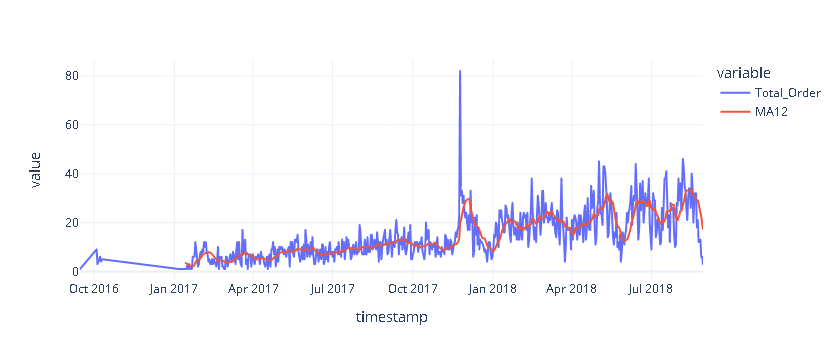

In [587]:
# create 12 month moving average
orders['MA12'] = orders['Total_Order'].rolling(12).mean()

# plot the data and MA
fig = px.line(orders, x="timestamp", y=["Total_Order", "MA12"], template = 'plotly_white')
fig.show()

In [588]:
orders.columns

Index(['timestamp', 'Total_Order', 'Month', 'Year', 'MA12'], dtype='object')

In [589]:
orders['timestamp'] = pd.to_datetime(orders['timestamp'])

In [591]:
# extract month and year from dates
orders['Day'] = [i.day for i in orders['timestamp']]
orders['Month'] = [i.month for i in orders['timestamp']]
orders['Year'] = [i.year for i in orders['timestamp']]
orders['day_of_week'] = [i.dayofweek for i in orders['timestamp']]
orders['day_of_year'] = [i.dayofyear for i in orders['timestamp']]

# create a sequence of numbers
orders['Series'] = np.arange(1,len(orders)+1)

# drop unnecessary columns and re-arrange
orders.drop(['MA12'], axis=1, inplace=True)
orders = orders[['timestamp','Series', 'Year', 'Month', 'Day','day_of_week', 'day_of_year', 'Total_Order']] 

# check the head of the dataset
orders

,timestamp,Series,Year,Month,Day,day_of_week,day_of_year,Total_Order
9569,2016-09-15,1,2016,9,15,3,259,1
9570,2016-10-04,2,2016,10,4,1,278,9
9571,2016-10-05,3,2016,10,5,2,279,3
9572,2016-10-06,4,2016,10,6,3,280,4
9573,2016-10-07,5,2016,10,7,4,281,5
...,...,...,...,...,...,...,...,...
10166,2018-08-25,598,2018,8,25,5,237,12
10167,2018-08-26,599,2018,8,26,6,238,13
10168,2018-08-27,600,2018,8,27,0,239,6
10169,2018-08-28,601,2018,8,28,1,240,6


In [592]:
orders_data = orders.copy()

#### Train Test Split

The data that will be divided is order data prior to 2018 as train data and order data after 2018 as test data. 

In [593]:
# split data into train-test set
train = orders[orders['Year'] < 2018]
test = orders[orders['Year'] >= 2018]

# check shape
train.shape, test.shape

((361, 8), (241, 8))

In [594]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 9569 to 9929
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    361 non-null    datetime64[ns]
 1   Series       361 non-null    int32         
 2   Year         361 non-null    int64         
 3   Month        361 non-null    int64         
 4   Day          361 non-null    int64         
 5   day_of_week  361 non-null    int64         
 6   day_of_year  361 non-null    int64         
 7   Total_Order  361 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(6)
memory usage: 24.0 KB


In [595]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 9930 to 10170
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    241 non-null    datetime64[ns]
 1   Series       241 non-null    int32         
 2   Year         241 non-null    int64         
 3   Month        241 non-null    int64         
 4   Day          241 non-null    int64         
 5   day_of_week  241 non-null    int64         
 6   day_of_year  241 non-null    int64         
 7   Total_Order  241 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(6)
memory usage: 16.0 KB


## Data Modeling

This model uses a time series model but is based on PyCaret regression. The target to be predicted is the total order. added numeric features, namely the year and the number of days in the year, and categorical features, namely the month and the number of days in the week where there are transactions.

In [596]:
# initialize setup
s = setup(data = train, test_data = test, target = 'Total_Order', fold_strategy = 'timeseries', numeric_features = ['Year', 'day_of_year'], categorical_features = ['Month', 'day_of_week'], 
          ignore_features = ['timestamp', 'Series'] ,fold = 3, transform_target = True, imputation_type='iterative', session_id = 123)

,Description,Value
0,session_id,123
1,Target,Total_Order
2,Original Data,"(361, 8)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(361, 22)"


AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'

In [597]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,3.3602,71.9313,4.8966,-0.4286,0.4779,0.2192,0.0333
lr,Linear Regression,3.6253,45.2548,5.3946,-1.0297,0.5548,0.3779,0.1400
en,Elastic Net,4.1542,45.1058,6.2272,-0.4344,0.4613,0.3909,0.0267
lasso,Lasso Regression,4.1614,45.2652,6.2391,-0.4395,0.4619,0.3913,0.0267
br,Bayesian Ridge,4.3022,47.3559,6.4307,-0.5655,0.4820,0.3911,0.0200
omp,Orthogonal Matching Pursuit,4.6004,48.4914,6.5595,-0.7164,0.5133,0.4451,0.0200
huber,Huber Regressor,4.6425,52.2636,6.7813,-0.7673,0.5446,0.4086,0.1333
ridge,Ridge Regression,4.6760,51.7447,6.8646,-0.9477,0.5643,0.4255,0.0467
ada,AdaBoost Regressor,4.7858,57.7737,7.1626,-1.0230,0.5760,0.4064,0.0700
catboost,CatBoost Regressor,5.0000,63.4852,7.4158,-1.0732,0.6266,0.4183,1.3500


The best model is the Least Angle Regression with an MAE of 3.36 and an RMSE of 4.89.

### Save Model

In [598]:
import sklearn.externals
import joblib

In [599]:
# Save the model
joblib.dump(best, 'model_demand_predict.pkl')

['model_demand_predict.pkl']

## Load Model to Data order

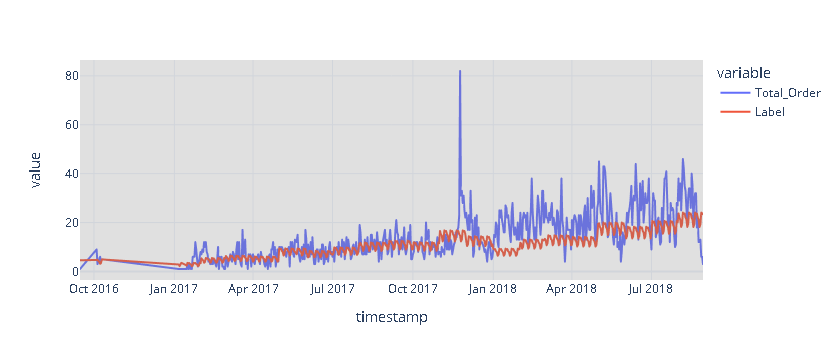

In [600]:
# generate predictions on the original dataset
predictions = predict_model(best, data=orders_data)

# line plot
fig = px.line(predictions, x='timestamp', y=["Total_Order", "Label"], template = 'plotly_white')

# add a vertical rectange for test-set separation**
fig.add_vrect(x0="2016-09-15", x1="2018-08-29", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

## Creatre Data for Prediction

The data to be predicted is from 30 August 2018 to 30 September 2019 on a daily basis.

In [609]:
future_dates = pd.date_range(start = '2018-08-30', end = '2019-09-30', freq = 'D')

future_df = pd.DataFrame()
future_df['timestamp'] = future_dates
future_df['Day'] = [i.day for i in future_df['timestamp']]
future_df['Month'] = [i.month for i in future_df['timestamp']]
future_df['Year'] = [i.year for i in future_df['timestamp']]   
future_df['day_of_week'] = [i.dayofweek for i in future_df['timestamp']]
future_df['day_of_year'] = [i.dayofyear for i in future_df['timestamp']]
future_df['Series'] = np.arange(603,(603+len(future_dates)))
future_df

,timestamp,Day,Month,Year,day_of_week,day_of_year,Series
0,2018-08-30,30,8,2018,3,242,603
1,2018-08-31,31,8,2018,4,243,604
2,2018-09-01,1,9,2018,5,244,605
3,2018-09-02,2,9,2018,6,245,606
4,2018-09-03,3,9,2018,0,246,607
...,...,...,...,...,...,...,...
392,2019-09-26,26,9,2019,3,269,995
393,2019-09-27,27,9,2019,4,270,996
394,2019-09-28,28,9,2019,5,271,997
395,2019-09-29,29,9,2019,6,272,998


In [610]:
predictions_future = predict_model(best, data=future_df)
predictions_future

,timestamp,Day,Month,Year,day_of_week,day_of_year,Series,Label
0,2018-08-30,30,8,2018,3,242,603,21.993195
1,2018-08-31,31,8,2018,4,243,604,21.242517
2,2018-09-01,1,9,2018,5,244,605,19.191616
3,2018-09-02,2,9,2018,6,245,606,20.315212
4,2018-09-03,3,9,2018,0,246,607,25.285429
...,...,...,...,...,...,...,...,...
392,2019-09-26,26,9,2019,3,269,995,41.873020
393,2019-09-27,27,9,2019,4,270,996,40.680893
394,2019-09-28,28,9,2019,5,271,997,35.787014
395,2019-09-29,29,9,2019,6,272,998,37.525948


## Save Result Prediction to CSV

In [611]:
predictions_future.to_csv('demand_prediction_health_beauty_.csv') 
print('Succes to csv')

Succes to csv


In [612]:
predictions_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    397 non-null    datetime64[ns]
 1   Day          397 non-null    int64         
 2   Month        397 non-null    int64         
 3   Year         397 non-null    int64         
 4   day_of_week  397 non-null    int64         
 5   day_of_year  397 non-null    int64         
 6   Series       397 non-null    int32         
 7   Label        397 non-null    float32       
dtypes: datetime64[ns](1), float32(1), int32(1), int64(5)
memory usage: 21.8 KB


In [613]:
concat_df = pd.concat([orders_data,predictions_future], axis=0)
concat_df

,timestamp,Series,Year,Month,Day,day_of_week,day_of_year,Total_Order,Label
9569,2016-09-15,1,2016,9,15,3,259,1.0,NaN
9570,2016-10-04,2,2016,10,4,1,278,9.0,NaN
9571,2016-10-05,3,2016,10,5,2,279,3.0,NaN
9572,2016-10-06,4,2016,10,6,3,280,4.0,NaN
9573,2016-10-07,5,2016,10,7,4,281,5.0,NaN
...,...,...,...,...,...,...,...,...,...
392,2019-09-26,995,2019,9,26,3,269,NaN,41.873020
393,2019-09-27,996,2019,9,27,4,270,NaN,40.680893
394,2019-09-28,997,2019,9,28,5,271,NaN,35.787014
395,2019-09-29,998,2019,9,29,6,272,NaN,37.525948


In [614]:
concat_df['timestamp'] = pd.to_datetime(concat_df['timestamp']).dt.date
concat_df

,timestamp,Series,Year,Month,Day,day_of_week,day_of_year,Total_Order,Label
9569,2016-09-15,1,2016,9,15,3,259,1.0,NaN
9570,2016-10-04,2,2016,10,4,1,278,9.0,NaN
9571,2016-10-05,3,2016,10,5,2,279,3.0,NaN
9572,2016-10-06,4,2016,10,6,3,280,4.0,NaN
9573,2016-10-07,5,2016,10,7,4,281,5.0,NaN
...,...,...,...,...,...,...,...,...,...
392,2019-09-26,995,2019,9,26,3,269,NaN,41.873020
393,2019-09-27,996,2019,9,27,4,270,NaN,40.680893
394,2019-09-28,997,2019,9,28,5,271,NaN,35.787014
395,2019-09-29,998,2019,9,29,6,272,NaN,37.525948


In [615]:
concat_df.set_index('timestamp', inplace=True)
concat_df

,Series,Year,Month,Day,day_of_week,day_of_year,Total_Order,Label
timestamp,,,,,,,,
2016-09-15,1,2016,9,15,3,259,1.0,NaN
2016-10-04,2,2016,10,4,1,278,9.0,NaN
2016-10-05,3,2016,10,5,2,279,3.0,NaN
2016-10-06,4,2016,10,6,3,280,4.0,NaN
2016-10-07,5,2016,10,7,4,281,5.0,NaN
...,...,...,...,...,...,...,...,...
2019-09-26,995,2019,9,26,3,269,NaN,41.873020
2019-09-27,996,2019,9,27,4,270,NaN,40.680893
2019-09-28,997,2019,9,28,5,271,NaN,35.787014


## Visualization Demand Prediction

The label is a demand prediction curve

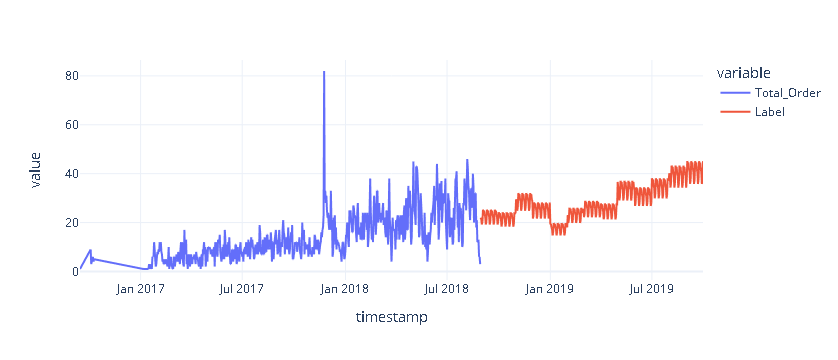

In [616]:
fig = px.line(concat_df, x=concat_df.index, y=["Total_Order", "Label"], template = 'plotly_white')
fig.show()

## Conclusion

The above model can still be imported, but it has several drawbacks, especially incomplete data. In the real business world, variables can be added to this demand prediction model, such as economic conditions, promo periods, or other categorical data. By adding these variables, one can make prediction results more accurate.